In [1]:
# !pip install python-Levenshtein
!pip install pybind11
!pip install fastwer
!pip install pytesseract
!sudo apt install tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fastwer: filename=fastwer-0.1.3-cp38-cp38-linux_x86_64.whl size=875356 sha256=7c6c67adad51ec5f95ed7820e631df70f2b280884afe30f9d5c9121f818176a9
  Stored in directory: /root/.cache/pip/wheels/87/7c/cc/6ba6edc83d9f67d96c02b4b7d31eb98284100d96389563db7c
Successfully built fastwer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (3,401 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pytesseract
import fastwer
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot



In [4]:
# !pip install unrar
# !unrar x /content/drive/MyDrive/data.rar
!unzip -O cp28596  /content/drive/MyDrive/data_no_pad.zip

Streaming output truncated to the last 5000 lines.
 extracting: data_no_pad/سطنرإج.png  
 extracting: data_no_pad/سطيماب.png  
 extracting: data_no_pad/سظ.png    
 extracting: data_no_pad/سظأسبكتهسجش.png  
 extracting: data_no_pad/سظثذسخكنيامنيذط.png  
 extracting: data_no_pad/سظثشجسظإسلز.png  
 extracting: data_no_pad/سظثغثاضعفإهضج.png  
 extracting: data_no_pad/سظحغفجرلوىأدخ.png  
 extracting: data_no_pad/سظددشوسي.png  
 extracting: data_no_pad/سظسمم.png  
 extracting: data_no_pad/سظغفواظر.png  
 extracting: data_no_pad/سظفغحفرمموظنر.png  
 extracting: data_no_pad/سع.png    
  inflating: data_no_pad/سعأضمىبلخخقصجك.png  
 extracting: data_no_pad/سعحجومعفجموط.png  
 extracting: data_no_pad/سعذأسحقظءحظأنج.png  
 extracting: data_no_pad/سعضضظنذازصرف.png  
 extracting: data_no_pad/سعظخنيطنعفظصخظس.png  
 extracting: data_no_pad/سعظصدذيو.png  
 extracting: data_no_pad/سععدىصيتتغو.png  
 extracting: data_no_pad/سعلأحلص.png  
 extracting: data_no_pad/سعوأل.png  
 extracting: data_no_pad/سغأتغ

In [5]:
def add_padding(labels):
  nlabels = []
  maxl = 0
  for l in labels:
    if len(l)> maxl:
      maxl = len(l)
  for l in labels:
    if len(l) < maxl:
      l += '0' * (maxl - len(l))
    nlabels.append(l)
  print('max lenght in data : ', maxl)
  return nlabels

In [14]:
# Path to the data directory
data_dir = Path("/content/data_no_pad")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
labels = add_padding(labels)
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 100

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

max lenght in data :  16
Number of labels found:  9224
Number of unique characters:  33
Characters present:  ['0', 'ء', 'أ', 'إ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']


## Preprocessing

In [15]:

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.75, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid_test, y_train, y_valid_test = split_data(np.array(images), np.array(labels))

x_test, x_valid,  y_test, y_valid = split_data(np.array(x_valid_test), np.array(y_valid_test), 0.8)

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32) 
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))[::-1]
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [16]:
labels[2]

'ءءإدميءىيدعأق000'

In [17]:
char_to_num(tf.strings.unicode_split(labels[2], input_encoding="UTF-8"))

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([ 2,  2,  4, 12, 28, 33,  2, 32, 33, 12, 22,  3, 25,  1,  1,  1])>

In [18]:
print('# of traning data : ', y_train.shape)
print('# of testing data : ', y_test.shape)
print('# of validation data : ', y_valid.shape)


# of traning data :  (6918,)
# of testing data :  (1844,)
# of validation data :  (462,)


## Create `Dataset` objects

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

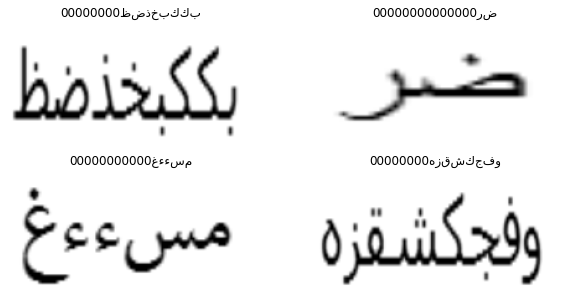

In [20]:
_, ax = plt.subplots(2, 2, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(4):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 2, i % 2].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 2, i % 2].set_title(label)
        ax[i // 2, i % 2].axis("off")
plt.show()

## Model

In [25]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)
    print(x)
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 35), dtype=tf.float32, name=None), name='dense2/Softmax:0', description="created by layer 'dense2'")
Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 100, 64  640         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 pool1 (MaxPooling2D)           (No

In [ ]:
char_to_num.get_vocabulary()

['[UNK]',
 '0',
 'ء',
 'أ',
 'إ',
 'ا',
 'ب',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي']

## Training

In [ ]:
# Model Training 
# we using Adam optimizer optimizer and 100 epochs 

In [ ]:
z
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_loss',
                               verbose=1, 
                               save_best_only=True)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, checkpointer],
)


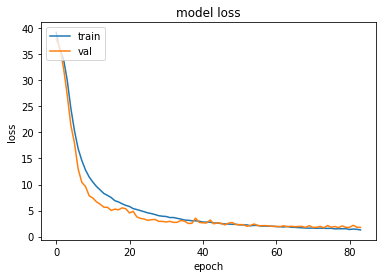

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Inference


In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
df = pd.DataFrame(columns = ['gt', 'pred', 'cer', 'wer'])

In [ ]:

#  Let's check results on some validation samples
gt = []
pred = []
cerl = []
werl = []
for batch in test_dataset.take(150):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    
    shape_val = 4
   # _, ax = plt.subplots(shape_val, shape_val, figsize=(30, 30))

    for i in range(len(pred_texts)):
        cer = fastwer.score_sent(pred_texts[i], orig_texts[i], char_level=True)
        wer = fastwer.score_sent(pred_texts[i], orig_texts[i], char_level=False)
        gt.append(orig_texts[i])
        pred.append(pred_texts[i])
        cerl.append(cer)
        werl.append(wer)
        # m = (distance(orig_texts[i], pred_texts[i]))
        # measure += m
        # img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        # img = img.T
        # title = f"Prediction: {pred_texts[i]} - CER : {cer} - WER : {wer}"
        # ax[i // shape_val, i % shape_val].imshow(img, cmap="gray")
        # ax[i // shape_val, i % shape_val].set_title(title)
        # ax[i // shape_val, i % shape_val].axis("off")
df['gt'] = gt
df['pred'] = pred
df['cer'] = cerl
df['wer'] = werl

# plt.show()

(16, 150, 75, 1)
1/1 [==============================] - 0s 25ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 31ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 31ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 27ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 26ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 26ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 27ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 24ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 33ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 28ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 30ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 24ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 28ms/step
(16, 150, 75, 1)
1/1 [==============================] - 0s 25ms/step
(16, 150, 75, 1)
1/1 [============

In [ ]:
df.head()

,gt,pred,cer,wer
0,000حكإمزيغاإويزش,0000حكإمزيغاإويز,10.3448,100.0
1,00000000000000ذه,00000000000000ذه,0.0000,0.0
2,0000000000غظدكغت,0000000000غظدكغت,0.0000,0.0
3,000000000منمثخقب,000000000منمثخقب,0.0000,0.0
4,000000وقطهدناإحق,000000وقطهدناإح[UNK],19.2308,100.0


In [ ]:
mean_cer = df['cer'].mean()
mean_wer = df['wer'].mean()
print(f' CER = {mean_cer}%')

 CER = 10.245982483731018%,  WER = 42.84164859002169%  Accuarcy = 89.75401751626899%
